# 基于pca+kmean的学生成绩预测

## 1. 引言

由于INT104要求我们写一个causework，课上要求使用的pca分析出主成分后再通过kmean分类，这个方法效果较差。本报告基于一个包含学生性别、年龄、系别、学习成绩等信息的数据集进行成绩预测。

## 2. 背景假设

我们认为学生成绩的好坏与其性别、年龄、系别等特征有一定的关系。通过对这些特征进行分析，我们可以建立一个预测模型，帮助我们更好地理解学生成绩的影响因素。

## 3. 数据集介绍

该数据集包括了多种学生特征信息，包括但不限于：
	•	性别：学生的性别可能与其成绩有一定的关系。
	•	年龄：年龄可能与学生的学习经验和心理成熟度相关。
	•	系别：不同系别的学生面对的课程难度及学习环境可能不同。
	•	成绩：学生的学习成绩，作为预测目标变量。

通过这些特征，我们可以构建一个用于预测学生成绩的模型。

## 4. 探索性数据分析（EDA）

在进行建模之前，我们首先进行数据的探索性分析，以便更好地理解数据的分布和潜在的关联性。以下是我们对数据集的初步分析：
	•	性别与成绩的关系：通过可视化和统计分析，探索性别是否对学生成绩有显著影响。
	•	年龄与成绩的关系：查看学生的年龄分布，以及不同年龄段学生成绩的表现。
	•	系别与成绩的关系：不同系别的学生可能在课程内容和难度上有所不同，因此成绩的分布可能呈现不同的模式。
	•	缺失值处理：老师在邮件中说明了数据不需要进行特殊处理，只需要关注数据集中的feature。

## 5. 基于贝叶斯的预测模型

在探索性数据分析的基础上，我们将利用贝叶斯定理构建预测模型。贝叶斯定理提供了一种通过先验知识与现有数据进行更新的方式，适用于处理不确定性和缺失信息的情境。

我们将设定以下假设：
	•	先验分布：对于每个系别和其他特征，我们设定先验分布，假设学生成绩的分布是已知的。
	•	似然函数：通过观测到的数据（如学生的性别、年龄、系别等），我们构建似然函数来描述数据与模型之间的关系。
	•	后验分布：结合先验分布和似然函数，我们可以计算出后验分布，并基于此预测学生的成绩。

## 6. 结论与下一步

在完成数据预处理后，我们将尝试通过pca寻找数据分布的特征，最后训练knn网络，评估模型的性能，并与其他预测方法进行对比。由于某些系类别的样本量较少，我们将使用交叉验证的方法来评估模型的泛化能力。同时，我们还将分析模型的特征重要性，以便了解哪些特征对成绩预测影响最大。

本报告的下一步将包括模型的实际应用与进一步的分析，以期实现更加精准的学生成绩预测。

In [28]:
import platform
# 导入所需库
import seaborn as sns
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline


warnings.filterwarnings('ignore')

# 按年级划分训练集
grade_models = {}

# 设置中文显示
system = platform.system()

if system == 'Darwin':  # Mac系统
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
elif system == 'Windows':  # Windows系统
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
elif system == 'Linux':  # Linux系统
    # Linux系统可能需要安装中文字体，例如 Noto Sans CJK SC
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']
else:
    # 默认字体（如果系统未识别）
    plt.rcParams['font.sans-serif'] = ['SimHei']

# 读取数据
df = pd.read_csv("./student_data.csv")

# 数据探索
print("数据基本信息:")
print(df.info())
print("\n数据统计摘要:")
print(df.describe())

# 检查缺失值
print("\n缺失值数量:")
print(df.isnull().sum())

# 查看各系别、年级、性别的学生分布
print("\n各系别学生数量:")
print(df['Programme'].value_counts())

print("\n各年级学生数量:")
print(df['Grade'].value_counts())

print("\n各性别学生数量:")
print(df['Gender'].value_counts())

print("\n各系别年级性别组合的学生数量:")
print(df.groupby(['Programme', 'Grade', 'Gender']).size())


数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      466 non-null    int64  
 1   Gender     466 non-null    int64  
 2   Grade      466 non-null    int64  
 3   Q1         466 non-null    int64  
 4   Q2         466 non-null    int64  
 5   Q3         466 non-null    int64  
 6   Q4         466 non-null    float64
 7   Q5         466 non-null    int64  
 8   Programme  466 non-null    object 
 9   Total      466 non-null    float64
dtypes: float64(2), int64(7), object(1)
memory usage: 36.5+ KB
None

数据统计摘要:
            Index      Gender       Grade          Q1          Q2          Q3  \
count  466.000000  466.000000  466.000000  466.000000  466.000000  466.000000   
mean   233.500000    1.641631    2.062232    6.633047    3.832618   10.740343   
std    134.666873    0.480037    0.241836    2.197873    2.428746    4.124822   
min   

接下来是学生的得分情况

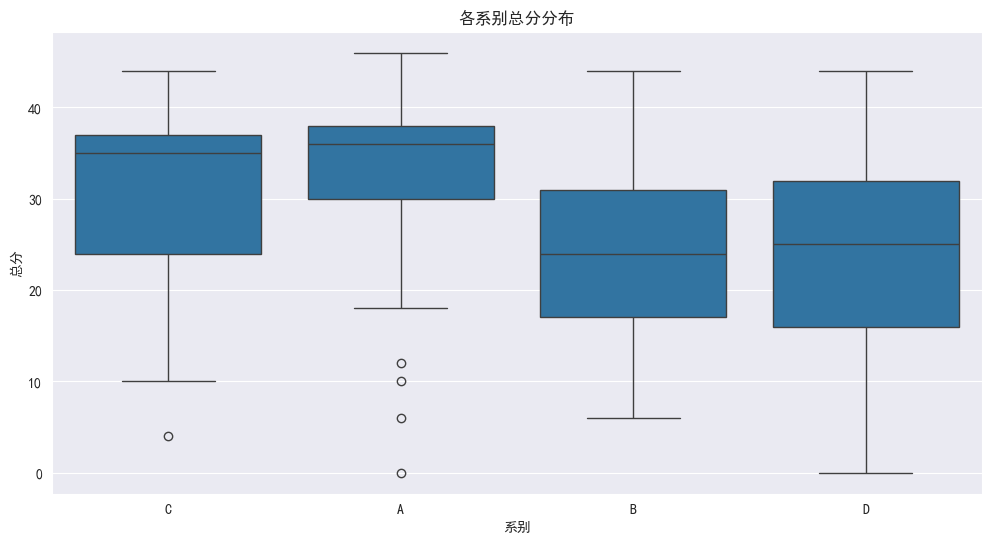

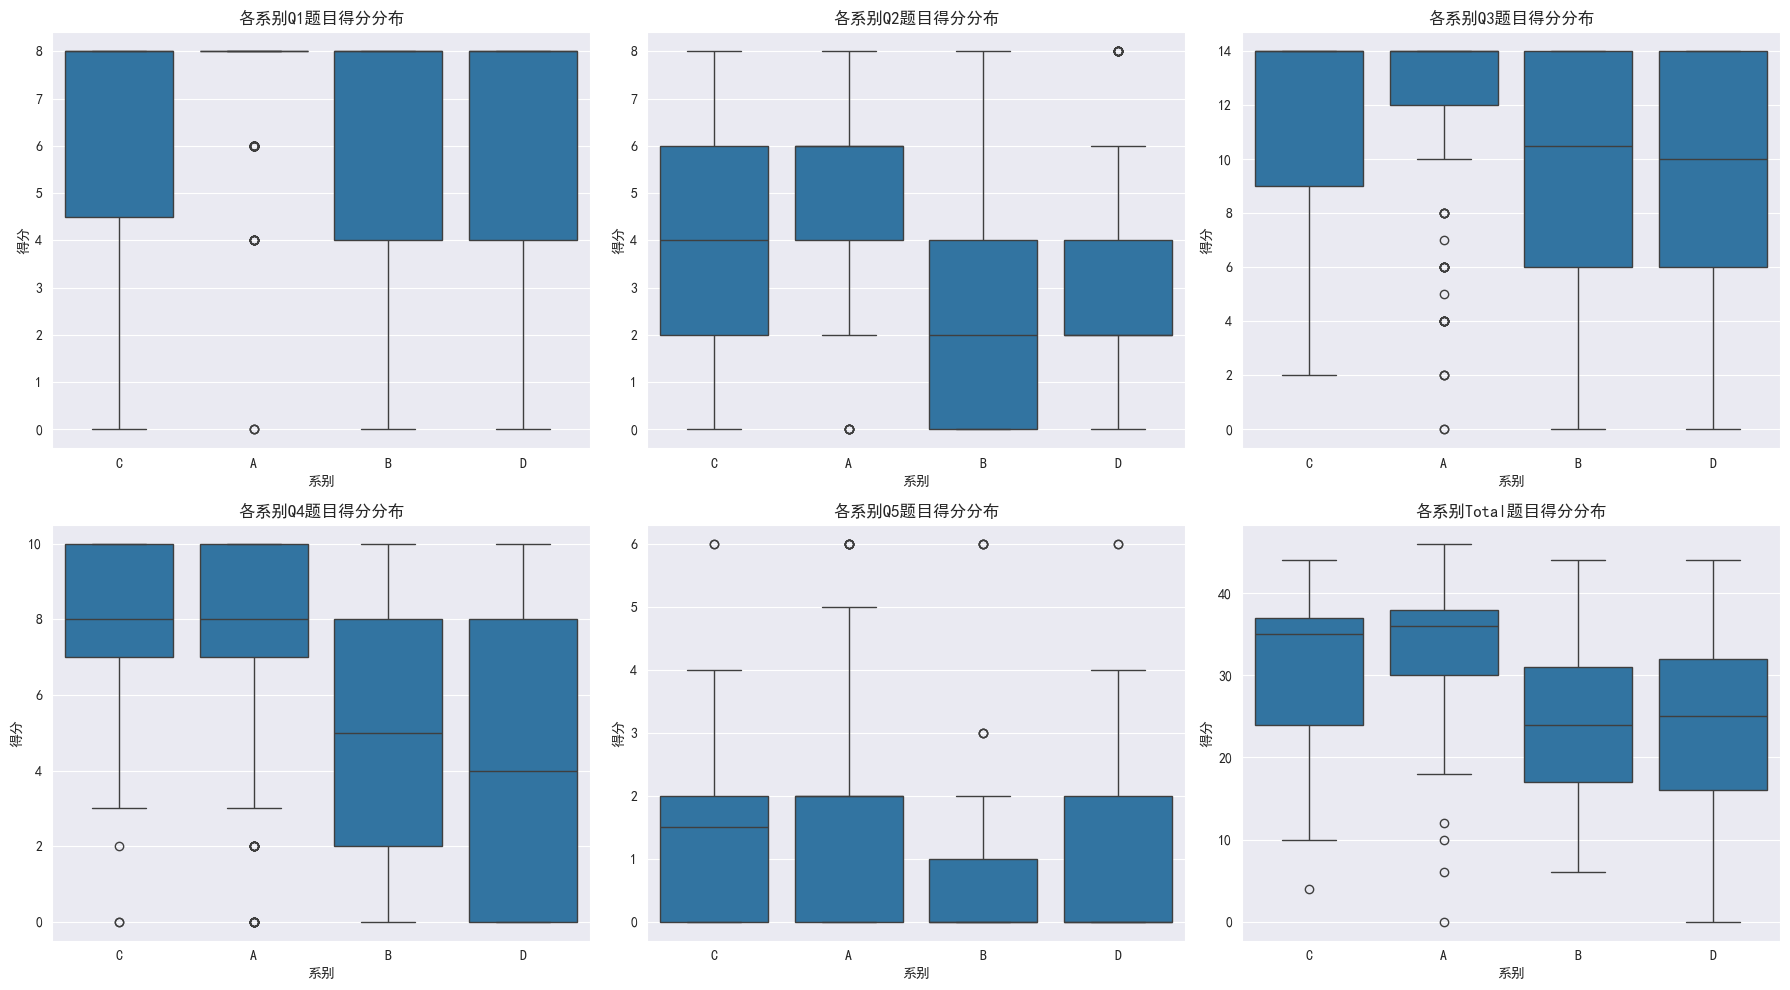

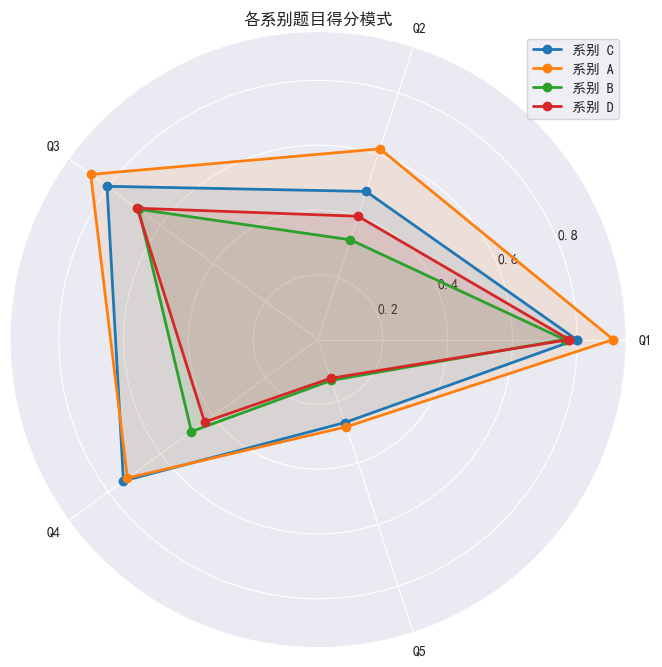

In [29]:

# 数据可视化：各系别总分分布
plt.figure(figsize=(12, 6))
sns.boxplot(x='Programme', y='Total', data=df)
plt.title('各系别总分分布')
plt.xlabel('系别')
plt.ylabel('总分')
plt.show()

# 各系别各题目得分分布
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Total']):
    sns.boxplot(x='Programme', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'各系别{col}题目得分分布')
    axes[i].set_xlabel('系别')
    axes[i].set_ylabel('得分')

plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# 准备雷达图数据
categories = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
programmes = df['Programme'].unique()

# 创建雷达图
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# 设置角度
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for p in programmes:
    # 计算该系的平均分
    stats = df[df['Programme'] == p][categories].mean() / np.array([8, 8, 14, 10, 6])  # 归一化
    stats = np.concatenate((stats, [stats[0]]))

    # 绘制该系的雷达线
    ax.plot(angles, stats, 'o-', linewidth=2, label=f'系别 {p}')
    ax.fill(angles, stats, alpha=0.1)

# 设置雷达图属性
ax.set_thetagrids(angles[:-1] * 180 / np.pi, categories)
ax.set_title('各系别题目得分模式')
ax.legend(loc='upper right')
plt.show()

## 2. 特征差异性分析

在学生成绩的预测过程中，各系别的特征差异性是一个重要的考虑因素。由于pca主成分分析是一个线性数据处理方法，如果原始输入数据和真实函数存在非线性关系，pca无法正确的提取特征。并且不同的学科和考试卷子具有不同的难度分布，不同系别的学生在面对这些考试时，其得分的特征也可能存在显著差异。这些差异可能源于以下几个因素：
	1.	课程难度：不同系别的课程内容和考试难度不同。例如，理工科类的学生可能面临更为复杂的数学题目，而文科类的学生则更多地涉及写作和理解类的题目。这些差异会导致各系别学生在考试中的得分分布呈现不同的特征。
	2.	学生能力差异：不同系别的学生可能具有不同的学习背景和能力分布。例如，某些系别的学生可能在基础知识掌握上更为扎实，而其他系别的学生则可能在某些领域表现得更为突出。这些能力差异会影响每个系别学生的得分分布。
	3.	考试题目类型：不同学科的考试题目类型有所差异，如选择题、填空题、简答题等，这也会影响不同系别学生的答题表现，从而导致得分分布的不同。
基于这些原因，我们需要对各系别的特征差异性进行深入分析，以便在后续的模型构建中考虑这些差异。

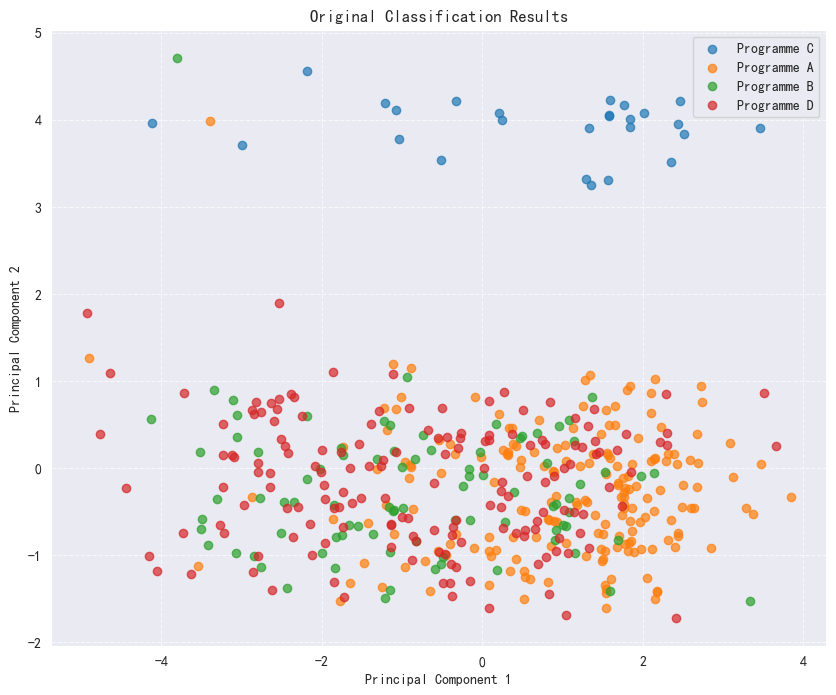

In [30]:
#使用经典pca分析


# 提取特征和目标变量
X = df.drop(columns=["Programme"])
y = df["Programme"]

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 尝试 PCA 降维（保留 95% 方差）
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# 可视化原始分类结果
plt.figure(figsize=(10, 8))
unique_programmes = y.unique()
for programme in unique_programmes:
    plt.scatter(X_pca[y == programme, 0], X_pca[y == programme, 1], label=f'Programme {programme}', alpha=0.7)

plt.title('Original Classification Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

说明原始数据并没有明显的线性可分性，接下来我们将使用多项式特征扩展、筛选有效数据类别来增加数据的非线性和线性特征，同时使用pipeline自动选择最有效的特征进行分类。

In [ ]:

# 创建PCA + 分类器的管道
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 定义参数网格
param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 15]
}

# 使用网格搜索查找最佳参数
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# 打印最佳参数和分数
print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证分数: {grid_search.best_score_:.4f}")

# 使用最佳参数进行PCA
best_components = grid_search.best_params_['pca__n_components']
best_pipeline = grid_search.best_estimator_

# 获取PCA结果用于可视化
pca = best_pipeline.named_steps['pca']
X_scaled = best_pipeline.named_steps['scaler'].transform(X)
X_pca = pca.transform(X_scaled)

# 可视化PCA结果
plt.figure(figsize=(10, 8))
for programme in y.unique():
    indices = y == programme
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=programme, alpha=0.7)

plt.title(f'PCA Visualization (Components={best_components})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 查看混淆矩阵
y_pred = best_pipeline.predict(X)
print("\n混淆矩阵:")
print(confusion_matrix(y, y_pred))
print("\n分类报告:")
print(classification_report(y, y_pred))

# 可视化各主成分的解释方差
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_, alpha=0.7)
plt.step(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), where='mid', color='red')
plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.5)
plt.xlabel('主成分数量')
plt.ylabel('解释方差比例')
plt.title('PCA解释方差')
plt.tight_layout()
plt.show()

最后验证数据集

In [17]:

# 读取数据
df = pd.read_csv("./test_data.csv")
# 提取特征和目标变量
X = pd.concat([df.drop(columns=["Programme", "MCQ", "Total"]), df["Total"]], axis=1)
mapping = {1: "A", 2: "B", 3: "C", 4: "D"}  # 你可以根据需要修改映射关系

df["Programme"] = df["Programme"].map(mapping)  # 或者使用 df["Programme"].replace(mapping)
y = df["Programme"]

y_pred = best_pipeline.predict(X)
print("\n混淆矩阵:")
print(confusion_matrix(y, y_pred))
print("\n分类报告:")
print(classification_report(y, y_pred))


混淆矩阵:
[[228   0   1  20]
 [ 60   3   1  54]
 [  0   0  35   0]
 [114   2   0 101]]

分类报告:
              precision    recall  f1-score   support

           A       0.57      0.92      0.70       249
           B       0.60      0.03      0.05       118
           C       0.95      1.00      0.97        35
           D       0.58      0.47      0.52       217

    accuracy                           0.59       619
   macro avg       0.67      0.60      0.56       619
weighted avg       0.60      0.59      0.53       619



可以看到其精度仅有0.59，说明数据集的特征差异性较大，可能需要更多的特征工程和模型调优来提高预测性能。或者者可以考虑使用其他的分类算法，如支持向量机、神经网络等，来进一步提高模型的性能。

从分类报告来看，这个模型的表现有一些问题，特别是在类别 B 和 D 上。让我们分析一下关键指标：

1. 准确率（Accuracy: 0.59）
	•	这是整体正确分类的比例，59% 的准确率在某些任务中可能尚可，但如果类别不均衡，可能会误导结果。

2. 精确率（Precision）
	•	A（0.57） 和 D（0.58） 的精确率一般，意味着它们的预测包含较多误判。
	•	B（0.60） 的精确率高于召回率，说明预测的 B 类不多，但大部分正确。
	•	C（0.95） 的精确率很高，几乎没有误判 C 类，但 C 类的样本较少（35 个）。

3. 召回率（Recall）
	•	A（0.92） 说明 A 类几乎都被正确识别，表现很好。
	•	B（0.03） 召回率极低，说明大多数 B 类被误分类到其他类别，模型 无法识别 B 类。
	•	C（1.00） 说明 C 类完全正确识别，但样本量很小（可能过拟合）。
	•	D（0.47） 召回率较低，意味着 D 类有 53% 的样本被误分类。

4. F1 分数
	•	A（0.70） 还算可以，受益于高召回率。
	•	B（0.05） 极差，说明 B 类几乎完全无法识别。
	•	C（0.97） 很好，但样本数太少，不能说明整体模型表现。
	•	D（0.52） 说明模型在 D 类上也有较大问题。

⸻

结论
	•	主要问题：
	1.	B 类的召回率极低（0.03），几乎不能正确分类 B 类，可能是数据不均衡或模型未能学习到 B 类的特征。
	2.	D 类的表现较差，召回率 0.47，说明模型对 D 类也有较多误判。
	3.	C 类表现好但样本量小（35 个），不能确定是否真正泛化良好。
	4.	整体 F1 分数不高（加权 F1 只有 0.53），说明模型并没有很好地兼顾所有类别。

改进建议
	1.	数据平衡
	•	检查 B 类样本是否太少，如果太少，可以考虑 数据增强 或 过采样（SMOTE）。
	•	如果某些类别数据过多，可以尝试 欠采样 其他类别。
	2.	调整分类权重
	•	训练时尝试 class_weight="balanced" 让模型更关注低召回率的类别（如 B 类）。
	•	在 sklearn 里，部分分类器（如 RandomForestClassifier、LogisticRegression）支持 class_weight 参数。
	3.	使用更复杂的模型
	•	试试 更复杂的模型（如 XGBoost、LightGBM）来提升分类效果。
	•	也可以使用 神经网络（如 MLP）尝试更深层的特征提取。
	4.	优化特征工程
	•	可能 B 和 D 类的特征没有被充分学习，可以尝试加入更多有用的特征或进行特征选择。
	5.	调参
	•	如果使用的是 SVM、决策树等模型，可以调节超参数（如 C、max_depth）来优化分类边界。

⸻

总结：目前模型的问题主要是 B 类召回率极低、D 类表现不佳，整体 F1 分数偏低（0.53）。可以尝试 数据增强、类别权重调整、改进模型和特征工程 来提升效果。🚀